In [34]:
import re
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
import numpy as np
import json
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nltk

In [35]:
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

In [36]:
def chunk_sentence(sentence, max_words=15):
    words = sentence.split()
    chunks = []
    for i in range(0, len(words), max_words):
        chunk = words[i:i+max_words]
        chunks.append(' '.join(chunk))
    return chunks

In [37]:
bk1 = open('book1.txt', 'r', encoding='utf-8').read().replace('\n', ' ').split('.')
bk1[1:3]

['  Everything was in confusion in the Oblonskys’ house',
 ' The wife had discovered that the husband was carrying on an intrigue with a French girl, who had been a governess in their family, and she had announced to her husband that she could not go on living in the same house with him']

In [38]:
bk2 = open('book2.txt', 'r', encoding='utf-8').read().replace('\n', ' ').split('.')
bk2[1:3]

[' It stands in the centre of a small bay, and upon a gentle acclivity, which, on one side, slopes towards the sea, and on the other rises into an eminence crowned by dark woods',
 ' The situation is admirably beautiful and picturesque, and the ruins have an air of ancient grandeur, which, contrasted with the present solitude of the scene, impresses the traveller with awe and curiosity']

In [39]:
raw_sentences = bk1 + bk2
sentences = []
max_words = 30
for sentence in raw_sentences:
    chunks = chunk_sentence(sentence, max_words=max_words)
    for c in chunks:
        if len(c) > 2:
            sentences.append(c)

In [40]:
sentences[:2]

['PART ONE Chapter 1 Happy families are all alike; every unhappy family is unhappy in its own way',
 'Everything was in confusion in the Oblonskys’ house']

In [41]:
len(sentences)

10627

In [42]:
def clean_text(text):
    text = text.lower()
    # Add spaces around punctuation
    text = re.sub(r'([^\w\s])', r' \1 ', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    # Normalize spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


def get_only_words(text):
    tokens = word_tokenize(text)
    words = [token for token in tokens if token.isalpha()]
    return words

In [43]:
sentences = [clean_text(txt) for txt in sentences]
len(sentences)

10627

In [44]:
sentences[1:3]

['everything was in confusion in the oblonskys house',
 'the wife had discovered that the husband was carrying on an intrigue with a french girl who had been a governess in their family and she had announced to her']

In [45]:
word_list1 = set(get_only_words("".join(bk2)))
word_list2 = set(get_only_words("".join(bk1)))
all_word_list = list(word_list1) + list(word_list2)
all_word_list[:3]

['expansive', 'heavens', 'gliding']

In [46]:
w_to_i = {word:i+2 for i, word in enumerate(set(all_word_list))}
w_to_i['<UNK>'] = 1
i_to_w = {v:k for k, v in w_to_i.items()}
with open('vocab.json', 'w') as fp:
    json.dump(w_to_i, fp)

In [47]:
vocab_size = len(set(w_to_i.values())) +1 #+1 for padding "0"
vocab_size

11130

In [48]:
def sentence_to_int(sentence):
    sentence_to_int = []
    for word in sentence.split(" "):
        int_word = w_to_i.get(word, w_to_i.get('<UNK>'))
        sentence_to_int.append(int_word)
    return sentence_to_int

In [49]:
sentence_to_int('everything was in confusion in the oblonskys house')

[5709, 1391, 3323, 10201, 3323, 40, 1, 3005]

In [50]:
int_sentences = [sentence_to_int(sentence) for sentence in sentences]
int_sentences[1]

[5709, 1391, 3323, 10201, 3323, 40, 1, 3005]

In [51]:
len(int_sentences)

10627

In [52]:
max(len(x) for x in int_sentences)

36

In [53]:
input_sq = []
output_sq = []
for sentence in int_sentences:
    for i in range(1, len(sentence)):
        temp = sentence[:i]
        pad = ( max_words - len(temp), 0)
        if temp != None:
            try:
                padded = F.pad(torch.tensor(temp), pad, value= 0)
            except Exception as e:
                print(e)
                print(sentence)
                print(temp)
                break

            input_sq.append(padded)
            output_sq.append(sentence[i])

In [54]:
len(input_sq)

175640

In [55]:
len(output_sq)

175640

In [56]:
class mydata(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [57]:
torch.manual_seed(10)
data = mydata(input_sq, torch.tensor(output_sq))
batched_data= DataLoader(data, 64, shuffle=True)

In [58]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embedding_dim=100, padding_idx = 0)
        self.do = nn.Dropout(.1)
        self.lstm = nn.LSTM(input_size = 100, hidden_size=150, num_layers=2, batch_first = True)
        self.layers = nn.Sequential(
            nn.Linear(in_features=150, out_features=200),
            nn.Dropout(.2),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=vocab_size)
        )
    def forward(self, x):
        x = self.emb(x)
        y = self.do(x)
        h, c = self.lstm(x)
        y = h[:, -1, :]
        y = self.layers(y)

        return y

In [59]:
def train(model, epochs, optim, loss_fn, patient = 3):
    model.train()
    best_loss = float('inf')
    epochs_loss = []
    for epoch in range(epochs):
        loss_ = []
        for batch in batched_data:
            x, y = batch
            x, y  = (x).to(device), (y).to(device)
            y_pred = model(x)

            loss = loss_fn(y_pred, y)
            loss.backward()
            optim.step()
            optim.zero_grad()

            loss_.append(loss.item())

        epoch_loss = np.mean(loss_)
        epochs_loss.append(epoch_loss)
        print(f"Epochs: {epoch} | Loss: {epoch_loss:.4f}")

        if best_loss > epoch_loss:
            best_loss = epoch_loss
            counter = 0
            torch.save(model.state_dict(), "best_model.pt")
            print(f"model saved with loss: {best_loss:.4f}")
        else:
            counter += 1
            if counter >= patient:
                print(f"Early stopping after {epoch} epochs without improvement")
                break

    return epochs_loss

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = (Model()).to(device)
optim = Adam(model.parameters(), lr = 0.001)
loss_fn = nn.CrossEntropyLoss(ignore_index=0) #ignoring padding
loss = train(model, 20, optim, loss_fn)

Epochs: 0 | Loss: 6.2443
model saved with loss: 6.2443
Epochs: 1 | Loss: 5.6353
model saved with loss: 5.6353
Epochs: 2 | Loss: 5.3369
model saved with loss: 5.3369
Epochs: 3 | Loss: 5.0986
model saved with loss: 5.0986
Epochs: 4 | Loss: 4.8898
model saved with loss: 4.8898
Epochs: 5 | Loss: 4.6986
model saved with loss: 4.6986
Epochs: 6 | Loss: 4.5147
model saved with loss: 4.5147
Epochs: 7 | Loss: 4.3484
model saved with loss: 4.3484
Epochs: 8 | Loss: 4.1852
model saved with loss: 4.1852
Epochs: 9 | Loss: 4.0329
model saved with loss: 4.0329
Epochs: 10 | Loss: 3.8946
model saved with loss: 3.8946
Epochs: 11 | Loss: 3.7569
model saved with loss: 3.7569
Epochs: 12 | Loss: 3.6347
model saved with loss: 3.6347
Epochs: 13 | Loss: 3.5197
model saved with loss: 3.5197
Epochs: 14 | Loss: 3.4057
model saved with loss: 3.4057
Epochs: 15 | Loss: 3.3033
model saved with loss: 3.3033
Epochs: 16 | Loss: 3.2095
model saved with loss: 3.2095
Epochs: 17 | Loss: 3.1142
model saved with loss: 3.1142
Ep

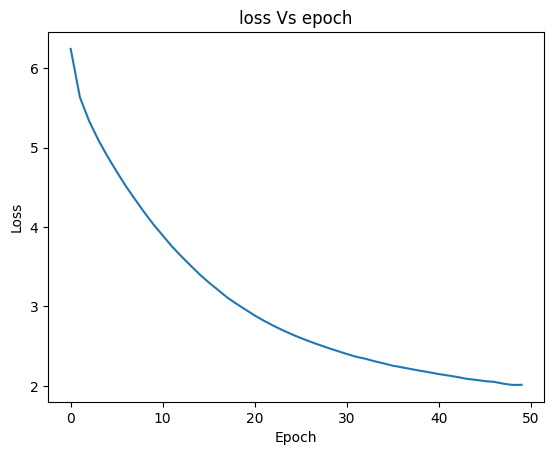

In [61]:
plt.plot([i for i in range(len(loss))], loss)
plt.title("loss Vs epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [94]:
x = 'can I go'

for j in range(20):
  with torch.no_grad():
    x_int = [w_to_i.get(i, 1) for i in x.lower().split()]
    x_tensor = torch.tensor(x_int).to(device)
    x_tensor = x_tensor.unsqueeze(0)
    y = model(x_tensor)
    y = i_to_w.get(torch.argmax(y).item())
    x = x + ' ' + y
    print(x)

can I go to
can I go to decorum
can I go to decorum without
can I go to decorum without deciding
can I go to decorum without deciding all
can I go to decorum without deciding all like
can I go to decorum without deciding all like peace
can I go to decorum without deciding all like peace and
can I go to decorum without deciding all like peace and m
can I go to decorum without deciding all like peace and m well
can I go to decorum without deciding all like peace and m well that
can I go to decorum without deciding all like peace and m well that s
can I go to decorum without deciding all like peace and m well that s what
can I go to decorum without deciding all like peace and m well that s what wicked
can I go to decorum without deciding all like peace and m well that s what wicked tongues
can I go to decorum without deciding all like peace and m well that s what wicked tongues do
can I go to decorum without deciding all like peace and m well that s what wicked tongues do said
can I go to